# Conferir  placa de video e cuda instalado

In [1]:
!nvidia-smi

Mon Nov 11 09:55:15 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   67C    P8              6W /   60W |     397MiB /   6144MiB |     21%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:55:00_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0


In [3]:
import torch
torch.cuda.is_available()

True

# Testando o yfinance para coleta de dados

In [4]:
import yfinance as yf

In [5]:
yf.download('CVCB3.SA', '1900-01-01').head(2)

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,CVCB3.SA,CVCB3.SA,CVCB3.SA,CVCB3.SA,CVCB3.SA,CVCB3.SA
Date,,,,,,
2013-12-09 00:00:00+00:00,11.172384,12.816148,12.857357,12.371085,12.791422,4377633
2013-12-10 00:00:00+00:00,11.423852,13.104614,13.187033,12.634826,12.634826,922360


# Criando funções para plotar dados de valor das ações

In [6]:
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

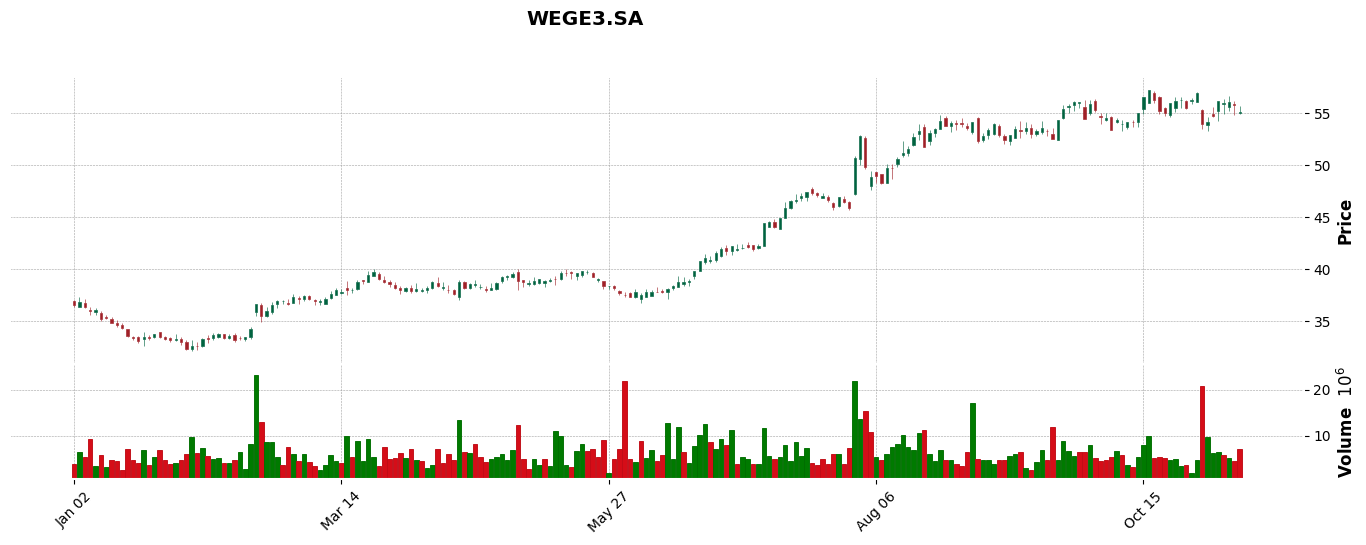

In [7]:
def ohlc_plot(ticker, inicio='1900-01-01', fim=None, period='max'):
    df: pd.DataFrame = yf.download(ticker, inicio, fim, period=period, progress=False)
    df.columns = df.columns.droplevel(1)
    return mpf.plot(df, type='candle', style='charles', volume=True, figratio=(25,8), title=ticker)

ohlc_plot('WEGE3.SA', '2024-01-01')

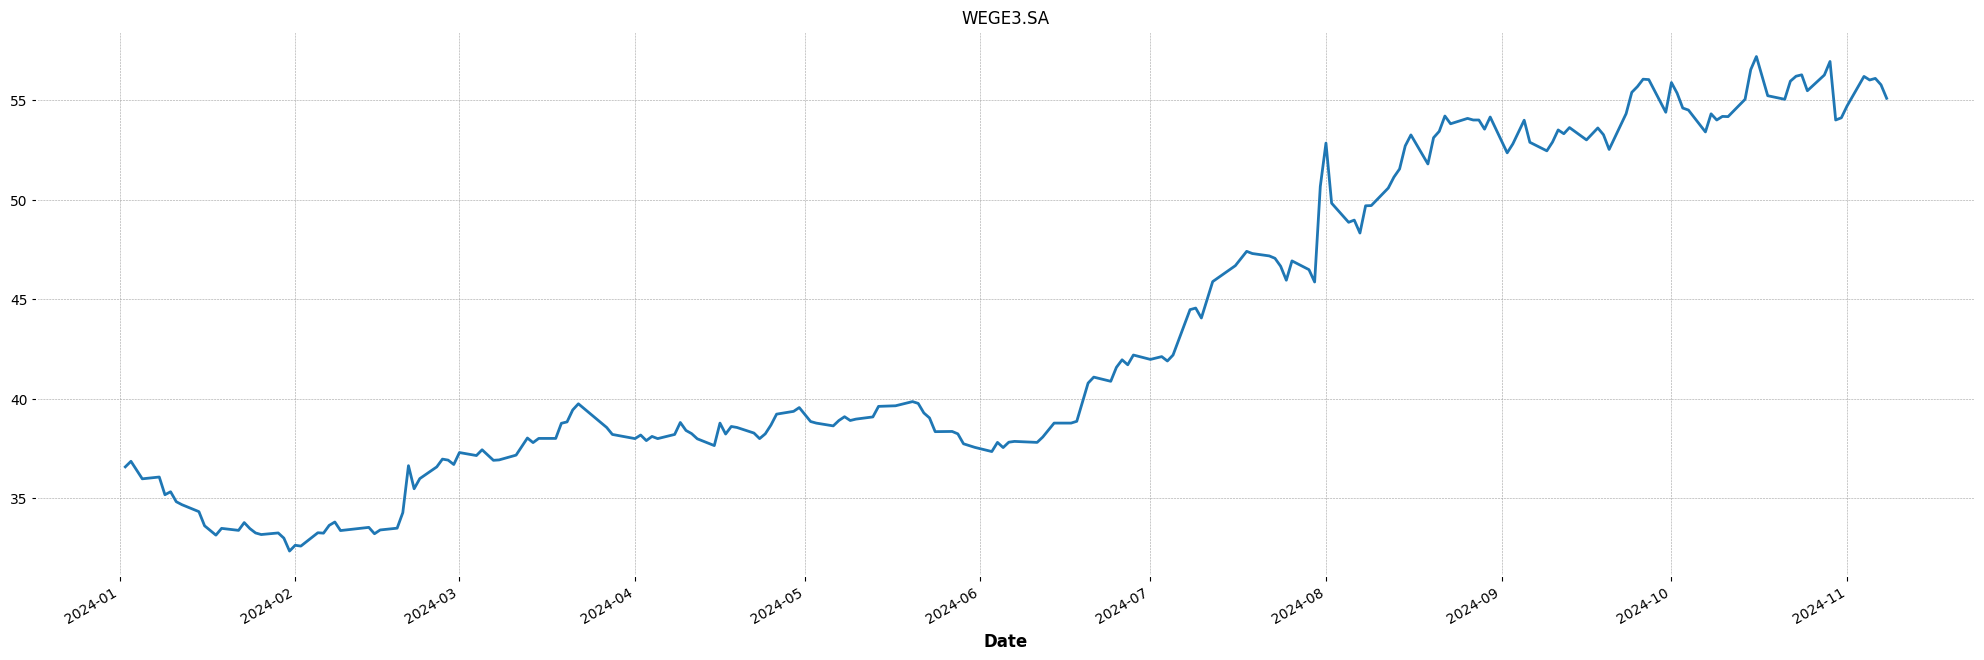

In [8]:
def plot_fechamento(ticker, inicio='1900-01-01', fim=None, period='max'):
    df: pd.DataFrame = yf.download(ticker, inicio, fim, period=period, progress=False)
    df.columns = df.columns.droplevel(1)
    return df['Close'].plot(figsize=(25,8), title=ticker)

plot_fechamento('WEGE3.SA', '2024-01-01');

# Criar dataset e dataloader para utilização no treinamento

In [9]:
from torch.utils.data import Dataset, DataLoader

In [10]:
class StockDataset(Dataset):
    def __init__(self, ticker, inicio='1900-01-01', fim=None, periodo='max', lookback=21, transformer=None, y_size=1):
        df = self._baixar_dados_acao(ticker, inicio, fim, periodo)

        self.transformer = transformer
        self.lookback = lookback
        self.y_size = y_size
        self.df = df
        self.close = df['Close'].to_numpy()

    def _baixar_dados_acao(self, ticker, inicio='1900-01-01', fim=None, periodo='max'):
        df = yf.download(ticker, inicio, fim, period=periodo, progress=False)
        df.columns = df.columns.droplevel(1)
        return df

    def __len__(self):
        return len(self.df) - self.lookback - self.y_size

    def __getitem__(self, idx):
        x = self.close[idx : idx+self.lookback]
        y = self.close[idx+self.lookback : idx+self.lookback+self.y_size]

        if self.transformer is not None:
            return self.transformer(x, y)
        return x, y 

In [11]:
ds = StockDataset('WEGE3.SA', '2024-01-01')

In [12]:
ds[0]

(array([36.56999969, 36.84999847, 36.36000061, 35.97000122, 36.06000137,
        35.16999817, 35.31999969, 34.81999969, 34.66999817, 34.31999969,
        33.61000061, 33.40000153, 33.13999939, 33.47999954, 33.38000107,
        33.77000046, 33.47000122, 33.25      , 33.16999817, 33.25      ,
        32.99000168]),
 array([32.34000015]))

In [13]:
for idx, (x, y) in enumerate(DataLoader(ds, batch_size=32, shuffle=False)):
    print(len(x), len(y))
    if idx == 3:
        break

32 32
32 32
32 32
32 32


# Transforma os dados para um formato amigavel para ML

In [14]:
close:np.array = ds.close
((close[1:] / close[:-1]) * 100)[:5]

array([100.76565158,  98.67029068,  98.92739444, 100.25020892,
        97.5318825 ])

O código anterior transforma cada item em uma procentagem com relação ao item anterior

In [15]:
def transforma_valores(x:np.array, y:np.float64):
    y = (y / x[-1]) * 100 - 100
    x = (x[1:] / x[:-1]) * 100 - 100
    return x, y

x, y = ds[0]
x_trans, y_trans = transforma_valores(x, y)

print(x, y)
print(x_trans, y_trans)

[36.56999969 36.84999847 36.36000061 35.97000122 36.06000137 35.16999817
 35.31999969 34.81999969 34.66999817 34.31999969 33.61000061 33.40000153
 33.13999939 33.47999954 33.38000107 33.77000046 33.47000122 33.25
 33.16999817 33.25       32.99000168] [32.34000015]
[ 0.76565158 -1.32970932 -1.07260556  0.25020892 -2.4681175   0.42650422
 -1.41562855 -0.43079129 -1.00951397 -2.06876192 -0.62481131 -0.77844947
  1.02595099 -0.29868123  1.16836242 -0.88836018 -0.65730867 -0.24060701
  0.24118732 -0.78194984] [-1.97029855]


In [16]:
def reverter_transformacao(ultimo_x:np.float64, y:np.float64):
    y = (y + 100) / 100 * ultimo_x
    return y

reverter_transformacao(x[-1], y_trans) 

array([32.34000015])

# Criando primeiro modelo de machine learning

In [17]:
from torch import nn
import torch

In [18]:
class RNN(nn.Module):
    def __init__(self, input_size:int, hidden_size:int, num_layers:int, output_size:int):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x:torch.tensor):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Testando a rede neural só para ver como vai se comportar

In [20]:
x,y = ds[0]

x_trans, y_trans = transforma_valores(x, y)
x_v = torch.from_numpy(x_trans).to(device)
net = RNN(20, 64, 2, 1).to(device)
out = net(x_v.unsqueeze(0).unsqueeze(0).float())

In [21]:
convertido = reverter_transformacao(x[-1], out.cpu().detach().numpy()[0][0])
print(y, convertido)

[32.34000015] 33.02659558840014


# Treina a rede neural

In [22]:
from tensorboardX import SummaryWriter

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((-1, 1))
scaler.fit(ds.close.reshape(-1, 1))

def tarnsformar_min_max(x:np.array, y:np.float64):
    x = scaler.transform(x.reshape(-1, 1)).reshape(-1)
    y = scaler.transform(y.reshape(-1, 1)).reshape(-1)
    return x, y

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(ds.close.reshape(-1, 1))

def tarnsformar_std(x:np.array, y:np.float64):
    x = scaler.transform(x.reshape(-1, 1)).reshape(-1)
    y = scaler.transform(y.reshape(-1, 1)).reshape(-1)
    return x, y

In [54]:
import datetime

torch.manual_seed(42)

input_size = 1
hidden_size = 5
num_layers = 1
output_size = 1

learning_rate = 0.001

num_epochs = 3000

net = RNN(input_size, hidden_size, num_layers, output_size).to(device)
net.train()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

ds = StockDataset('WEGE3.SA', '2010-01-01', '2022-01-01', transformer=tarnsformar_std)
dl = DataLoader(ds, batch_size=5000, shuffle=False)

text_time = datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S')
writer_name = f'runs/stock_rnn__{text_time}__is_{input_size}_hs_{hidden_size}_nl_{num_layers}_os_{output_size}_lr_{learning_rate}_epoch_{num_epochs}'
writer = SummaryWriter(writer_name)
print('Tensorboard log: ', writer_name)

last_loss = float('inf')
unchanged_loss_count = 0
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch}....')

    for idx, (x, y) in enumerate(dl):
        x = x.to(device).float().unsqueeze(2)
        y = y.to(device).float()

        out = net(x)
        optimizer.zero_grad()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        writer.add_scalar('Loss/train', loss.item(), epoch * len(dl) + idx)

        if idx % 10 == 0:
            print(f'Epoch {epoch} Iteration {idx} Loss {loss.item()}')

        if round(loss.item(), 4) == round(last_loss, 4):
            unchanged_loss_count += 1
        else:
            unchanged_loss_count = 0

        if unchanged_loss_count > 25:
            print('Early stopping...')
            break

        last_loss = loss.item()
    
    if unchanged_loss_count > 25:
        break

writer.close()


Tensorboard log:  runs/stock_rnn__2024.11.12.08.41.11__is_1_hs_5_nl_1_os_1_lr_0.001_epoch_3000
Starting epoch 0....
Epoch 0 Iteration 0 Loss 18.02420425415039
Starting epoch 1....
Epoch 1 Iteration 0 Loss 17.99198341369629
Starting epoch 2....
Epoch 2 Iteration 0 Loss 17.959522247314453
Starting epoch 3....
Epoch 3 Iteration 0 Loss 17.92681312561035
Starting epoch 4....
Epoch 4 Iteration 0 Loss 17.89385223388672
Starting epoch 5....
Epoch 5 Iteration 0 Loss 17.860628128051758
Starting epoch 6....
Epoch 6 Iteration 0 Loss 17.827129364013672
Starting epoch 7....
Epoch 7 Iteration 0 Loss 17.793354034423828
Starting epoch 8....
Epoch 8 Iteration 0 Loss 17.759286880493164
Starting epoch 9....
Epoch 9 Iteration 0 Loss 17.724918365478516
Starting epoch 10....
Epoch 10 Iteration 0 Loss 17.690237045288086
Starting epoch 11....
Epoch 11 Iteration 0 Loss 17.655237197875977
Starting epoch 12....
Epoch 12 Iteration 0 Loss 17.61989974975586
Starting epoch 13....
Epoch 13 Iteration 0 Loss 17.58421134

In [57]:
with torch.no_grad():
    net.eval()

    tds = StockDataset('WEGE3.SA', '2022-01-01', '2024-01-01', transformer=tarnsformar_min_max)

    for idx, (x, y) in enumerate(DataLoader(tds, batch_size=5000, shuffle=False)):
        x = x.to(device).float().unsqueeze(2)
        out = net(x)
        y = scaler.inverse_transform(y.squeeze().cpu().numpy().reshape(-1, 1))
        out = scaler.inverse_transform(out.squeeze().cpu().numpy().reshape(-1, 1))
        print(y[0], out[0])
    

[32.06000137] [32.386257]


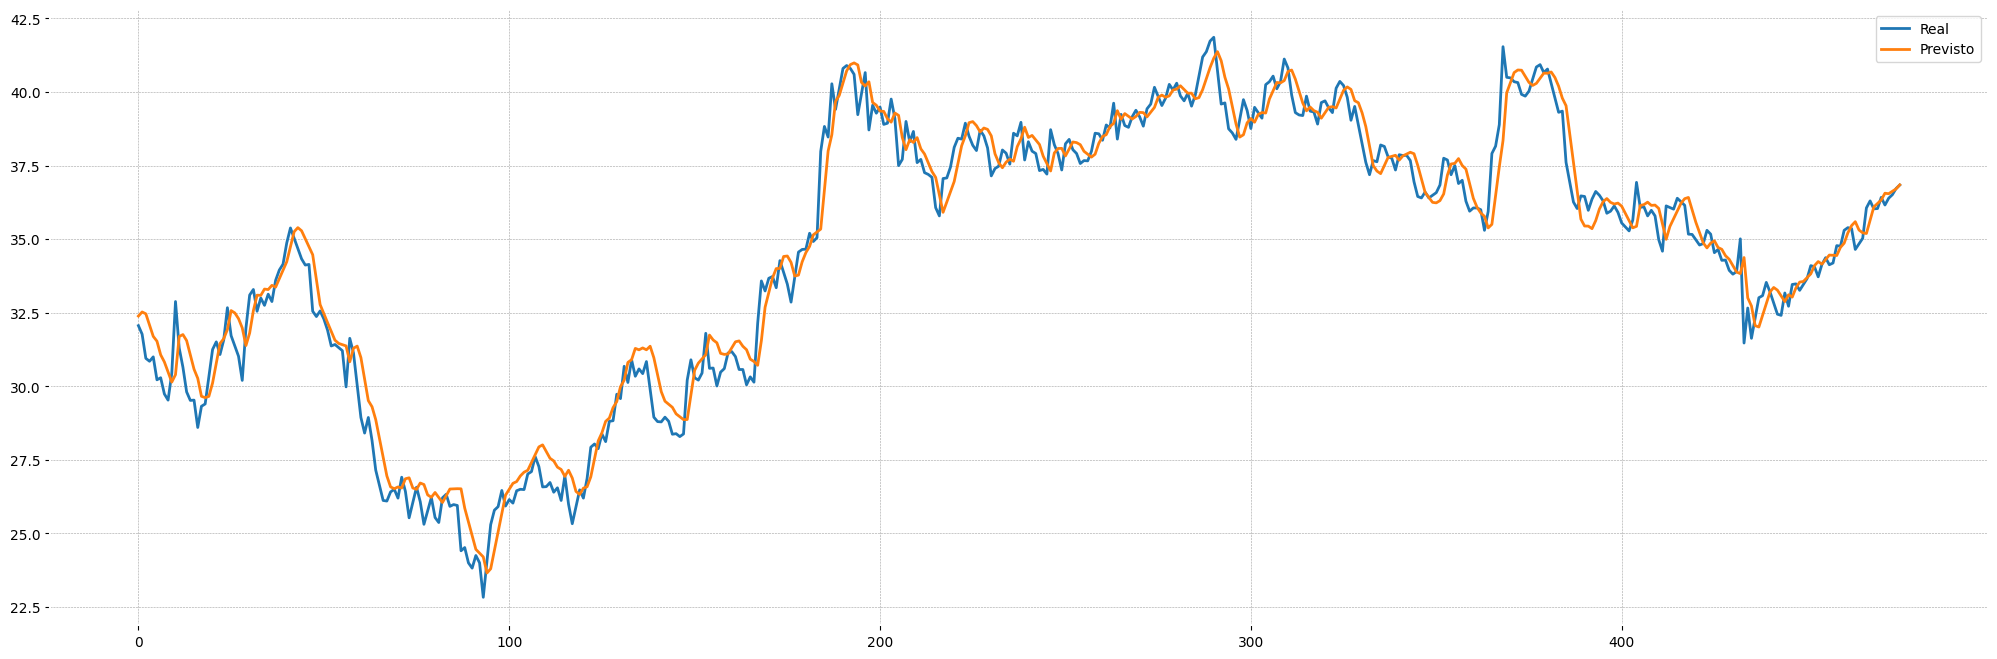

In [62]:
plt.figure(figsize=(25,8))
plt.plot(y, label='Real')
plt.plot(out, label='Previsto')
plt.legend();

In [79]:
from pathlib import Path
import joblib

Path('app/models').mkdir(exist_ok=True, parents=True)

torch.save(net.state_dict(), 'app/models/stock_rnn.pth')
joblib.dump(scaler, 'app/models/stock_rnn_scaler.pkl')

['app/models/stock_rnn_scaler.pkl']